In [1]:
### decodingCallTypes 3 uses the information from part2

In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import multiprocessing as mp
from scipy.stats import t
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb
from scipy.stats import norm

from decoders import naiveBayes

import config

In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Google Drive/My Drive/julie/'
pklPath = 'pkl/'


# The 6 birds from Julie data set
birds = ['BlaBro09xxF', 'GreBlu9508M', 'WhiBlu5396M', 'LblBlu2028M', 'WhiWhi4522M', 'YelBlu6903F']

# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [3]:
# Load the data base
outPath = rootPath+'JulieDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

/Users/frederictheunissen/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']
# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

In [5]:
# read unitList and argList2 and Confusion matrices data base
inPath = rootPath+ pklPath + 'JulieDataBaseGoodUnitList.pkl' 
fileIn = open(inPath,"rb")
argList2 = pk.load(fileIn)
unitList = list(pk.load(fileIn))

fileIn.close()

In [6]:
# read unitList and argList2 and Confusion matrices data base
inPath = rootPath+ pklPath + 'JulieDataBaseGoodUnitList10.pkl' 
fileIn = open(inPath,"rb")
argList10 = pk.load(fileIn)
unitList10 = list(pk.load(fileIn))

fileIn.close()

In [7]:
print(len(unitList))
print(len(unitList10))

408
375


In [8]:
siteList = pd.read_csv(rootPath+'h5_listFiles_CallProtocol.txt', sep='\s+', header=None, names = ['CellNumber', 'Path'])

birdL = []
siteL = []

for path in siteList['Path']:
    pathSplit = path.split("/")
    bird = pathSplit[5]
    site = (pathSplit[6].split('.')[0])[0:-3]
    birdL.append(bird)
    siteL.append(site)

In [9]:
# Printing the name of the most discriminating units
birdName = []
for unit in unitList10:
    ind = siteL.index(unit[0:-7])
    birdName.append(birdL[ind])
    
birdUnique = np.unique(birdName)
for bird in birdUnique:
    print(bird, ":", len([x for x in birdName if x == bird]))

BlaBro09xxF : 21
GreBlu9508M : 171
WhiWhi4522M : 83
YelBlu6903F : 100


In [10]:
# Generates the common stimulus set
def commonStim(siteUnit, unitList):
      
    for i, unit in enumerate(unitList):
        tempStims = np.unique(dfDataBaseNW['stim'][siteUnit==unit].values)
        if i == 0 :
            stimSet = set(tempStims)
        stimSet = stimSet.intersection(tempStims)
                               
    return stimSet
        

In [11]:
# For 1 and 2 - see part 2
numUnits = 15

#nGood = len(unitList)
nGood = len(unitList10)

maxTest = 4000  # This is 10000 in version 1 and 1800 for version 2 (with more permutations)
siteUnit = (dfDataBaseNW['site']+'_'+dfDataBaseNW['unit'])


ntests = int(comb(nGood,numUnits))
if ntests > maxTest:
    ntests = maxTest
    
#nGoodPairs = len(argList2)
nGoodPairs = len(argList10)

# Generate the list of arguments to run naiveBayes in parallel
i = 0
argList = []
while i <ntests:
    # Choose two at first
    #unitChoice = argList2[np.random.randint(nGoodPairs)]
    
    # Choose 10 at first
    unitChoice = argList10[np.random.randint(nGoodPairs)]
    
    # choose additional ones, one by one:
    unitListTest = unitList10.copy()
    while (len(unitChoice) < numUnits) & (len(unitListTest) > 0) :
        newUnit = np.random.choice(unitListTest, 1, replace=False)
        if newUnit in unitChoice:
            unitListTest.remove(newUnit)
            continue
        testCombo = True
        for testUnit in unitChoice:
            testList = [testUnit, newUnit]
            testList2 = [newUnit, testUnit]
            if (testList in argList2) | (testList2 in argList2) :
                continue
            else:
                testCombo = False
                break
        if testCombo == False:
            unitListTest.remove(newUnit)
            break
        unitChoiceTemp = unitChoice.copy()
        unitChoiceTemp.append(newUnit[0])
        
        stimSet = commonStim(siteUnit, unitChoiceTemp)
        if len(stimSet) > 100 :
            unitChoice.append(newUnit[0])

        else:
            unitListTest.remove(newUnit)
    
    if (len(unitChoice) == numUnits) & (unitChoice not in argList):
        argList.append(unitChoice)
        i += 1
        if (i%1000 == 0 ):
            print(i, '...')



1000 ...


KeyboardInterrupt: 

In [12]:
i

1358

In [ ]:
unitList20 = np.unique([unit for sublist in argList for unit in sublist])

In [15]:
# save unitList and argList and Confusion matrices data base
outPath = rootPath+ pklPath + 'JulieDataBaseGoodUnitList20V2.pkl' 
fileOut = open(outPath,"wb")
pk.dump(argList, fileOut)
pk.dump(unitList20, fileOut)

fileOut.close()

In [13]:
# read unitList from previous run
inPath = rootPath+ pklPath + 'JulieDataBaseGoodUnitList20.pkl' 
fileIn = open(inPath,"rb")
argList = pk.load(fileIn)
unitList20 = pk.load(fileIn)
numUnits = 20

fileIn.close()

In [14]:
print('Unit List has', len(unitList20), 'units')
print('arglist has', len(argList), 'combinations')

Unit List has 364 units
arglist has 1358 combinations


In [15]:
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

In [20]:
numUnits = 15
newArgList = []
for sublist in argList:
    newArgList.append(sublist[0:numUnits])


In [22]:
argList = newArgList

In [23]:
code = 'PC'

# Run Naive Bayes in chunks of 100 with a pool of 10 workers
chunckSize = 90    # A chunk size of 100 or 90 is used for memory since it has to keep the results of all
poolSize = 30

ntests = len(argList)

# Allocate memory for results
pcc = np.zeros((ntests,))
confMatTot = np.zeros((ncalls, ncalls))
confMatCount = 0
confMatFits = 0

# Calculate the number of chunks
nchunks = ntests//chunckSize
if nchunks % chunckSize:
    nchunks += 1

if __name__ == '__main__':
    for ichunk in range(nchunks):
        istart = ichunk*chunckSize
        iend = (ichunk+1)*chunckSize
        if iend > ntests:
            iend = ntests         
        
        with mp.Pool(poolSize) as p:
            results = p.map(naiveBayes, argList[istart:iend])
        
        # I don't think I need these??
        # p.close()
        # p.join()
        
        for i, res in enumerate(results):
            pcc[istart + i] = res[0]
            confMat = res[1]
            testsPerClass = res[2]
            # fitsPerClass = res[3]
            if (confMat.shape == (ncalls,ncalls) ) :
                confMatTot = np.add(confMatTot, confMat)
                confMatCount += testsPerClass
                # confMatFits += fitsPerClass
                
        print('Done with chunk %d/%d' % (ichunk, nchunks))

# Calculate the average confusion matrix. 
for i in range(ncalls):
    if confMatCount[i] > 0:
        confMatTot[i,:] = confMatTot[i,:]/confMatCount[i]
        





Done with chunk 0/16
Done with chunk 1/16
Done with chunk 2/16
Done with chunk 3/16
Done with chunk 4/16
Done with chunk 5/16
Done with chunk 6/16
Done with chunk 7/16
Done with chunk 8/16
Done with chunk 9/16
Done with chunk 10/16
Done with chunk 11/16
Done with chunk 12/16
Done with chunk 13/16
Done with chunk 14/16
Done with chunk 15/16


In [24]:
# save the PC and Confusion matrices data base
outPath = rootPath+ pklPath + 'JulieDataBase%dGoodUnitPC.pkl' % numUnits
fileOut = open(outPath,"wb")
pk.dump(argList, fileOut)
pk.dump(confMatTot, fileOut)
pk.dump(pcc, fileOut)
pk.dump(confMatCount, fileOut)
# pk.dump(confMatFits, fileOut)
fileOut.close()

In [25]:
confMatCount

array([14199., 16110., 21975.,  9852., 10662., 19020., 36852., 24444.,
        9700.])

In [26]:
pcc

array([52.64084828, 59.26990611, 57.68208184, ..., 58.65682972,
       47.60428432, 45.47543342])

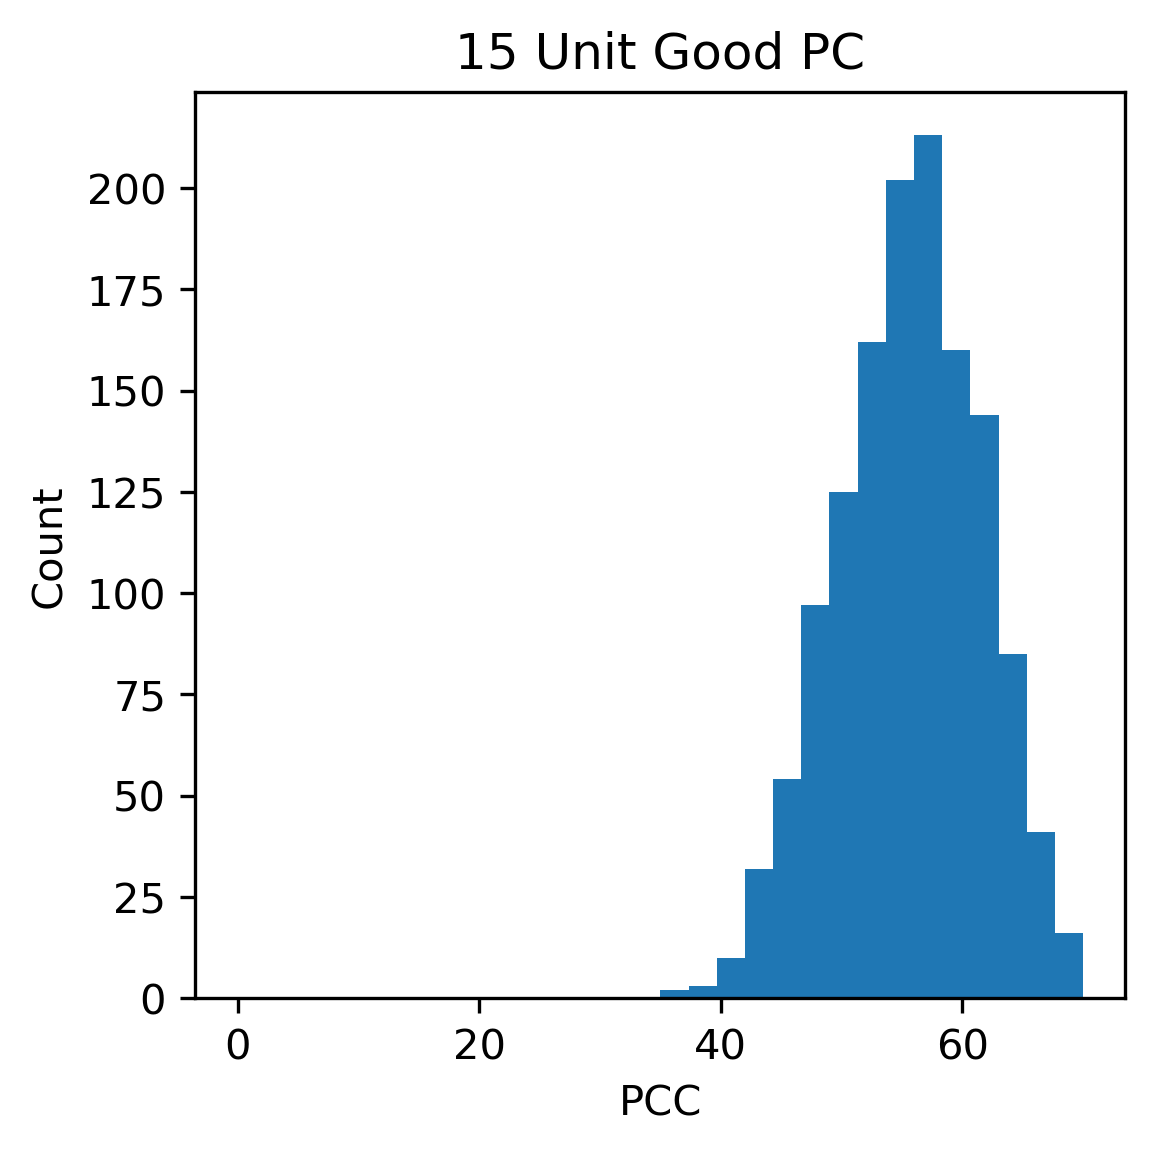

In [27]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

ax.hist(pcc, bins = 30, range = (0,70))
ax.set_xlabel('PCC')
ax.set_ylabel('Count')
ax.set_title('%d Unit Good PC' % numUnits)

plt.savefig('/Users/frederictheunissen/Desktop/pcchist%dUnitGoodPCJulieV2.eps' % numUnits)

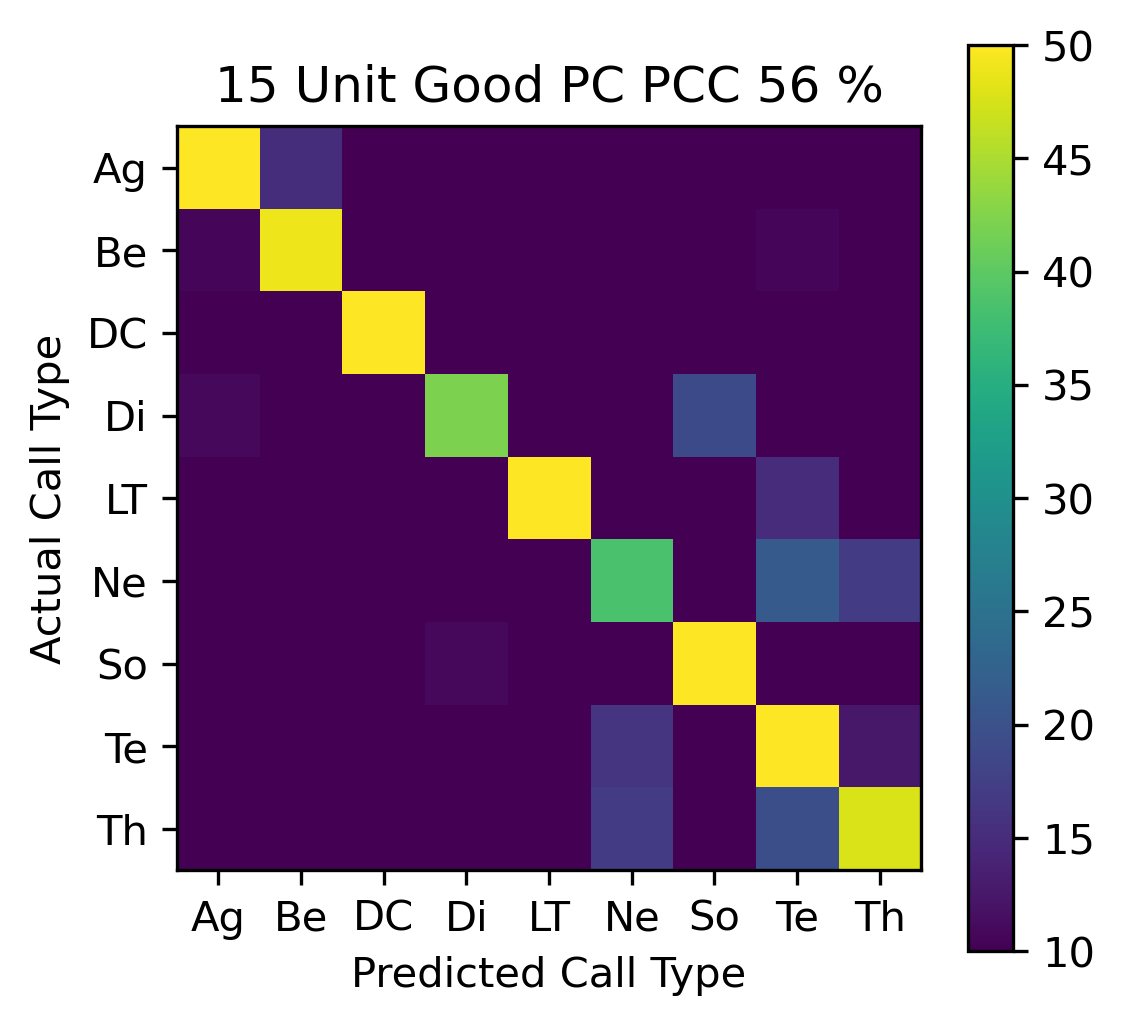

In [28]:
# Plot the overall confusion matrix

cmap='viridis'
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()
im_ = ax.imshow(confMatTot*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=10, vmax = 50)

fig.colorbar(im_, ax=ax)
ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               xticklabels=callNames,
               yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='%d Unit Good PC PCC %.0f %%' % (numUnits, np.mean(pcc)))

plt.savefig('/Users/frederictheunissen/Desktop/confMat%dUnitGoodPCJulieV2.eps' % numUnits)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


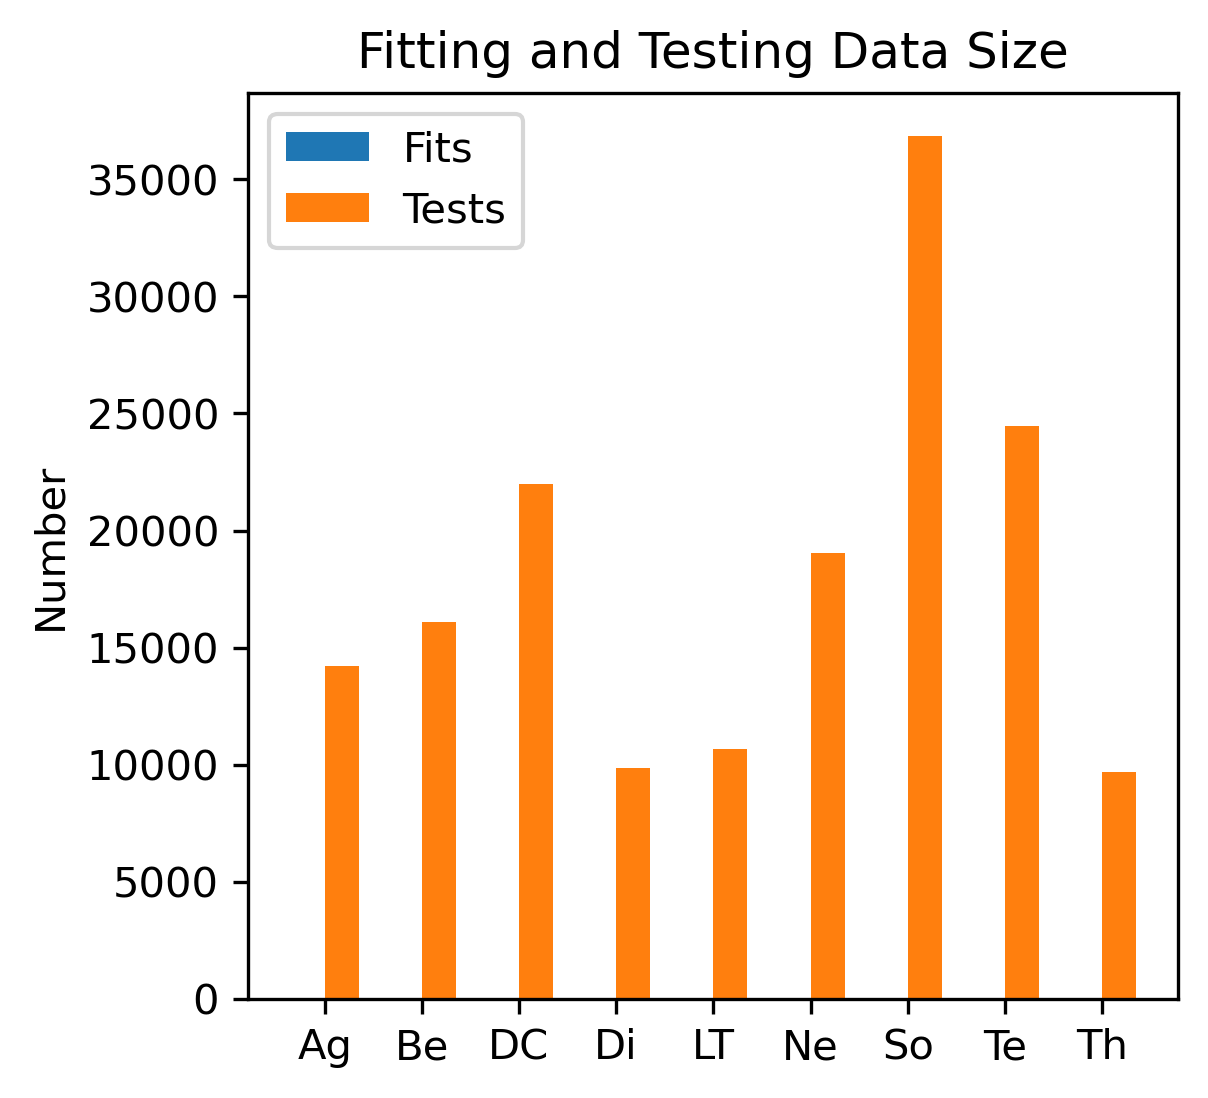

In [30]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

x = np.arange(len(callNames))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, confMatFits, width, label='Fits')
rects2 = ax.bar(x + width/2, confMatCount, width, label='Tests')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number')
ax.set_title('Fitting and Testing Data Size')
ax.set_xticks(x)
ax.set_xticklabels(callNames)
ax.legend()

plt.savefig('/Users/frederictheunissen/Desktop/dataSize%dUnitGoodPCJulieV2.eps' % numUnits)